In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import time
import scipy.optimize as opt
import os

**Reading in Data**

In [2]:
path = 'C:\\Users\\maxse\\Python_Projects\\LMU\\Observation-and-Data-Processing\\'
data_yalis = np.loadtxt(path + '/yalis_130417_raw.txt', delimiter = ',')   #delimiter seperates values by ',' ; I might also need to skiprows = 1 sometimes

data_doas = np.array([[float(i) for i in (' '.join(line.split())).split(' ')] for line
in open(path + 'no2_doas_data.txt').readlines()[1:]])

#check if data is looking good:

print(data_yalis)

#if there are NANs we want to get rid of:

removeNANs = False

if(removeNANs == True):
    
    data_no_nans = []

    for i in range(0, len(data_yalis), 1):
        if(np.isnan(data_yalis[i,0]) == False and np.isnan(data_yalis[i,2]) == False):    #positions to check for NANs of course depend on the txt file! I need to look that up
            data_no_nans.append(data[i])
    data_yalis = np.array(data_no_nans)
    

#often times first row/column(!) is a time scale and next rows/columns are different variables (i.e. for NO2 DOAS measurements)

#time = data[:,0]
#var1 = data[:,1]
#var2 = data[:,2]
#var3 = data[:,3]
#var4 = data[:,4]

#but sometimes they're also just a 2D/3D field



[[ 5.7948e-03  6.2871e-03  5.8365e-03 ...  1.3900e-02  1.4798e-02
   1.5067e-02]
 [ 1.5975e-02  1.6017e-02  1.6186e-02 ...  3.8340e-02  3.7158e-02
   3.6657e-02]
 [ 4.5695e-02  4.5417e-02  4.6576e-02 ...  1.0363e-01  1.0768e-01
   1.0183e-01]
 ...
 [ 7.9482e-04  8.8713e-04  8.3646e-04 ...  7.1966e-04  1.2282e-03
   7.9666e-04]
 [ 7.7482e-04  1.6713e-04 -1.3541e-05 ...  5.8966e-04  1.4482e-03
   4.4666e-04]
 [ 8.4482e-04  7.2713e-04  1.0465e-03 ... -1.0343e-05  1.7082e-03
   5.9666e-04]]


**Display the Data**

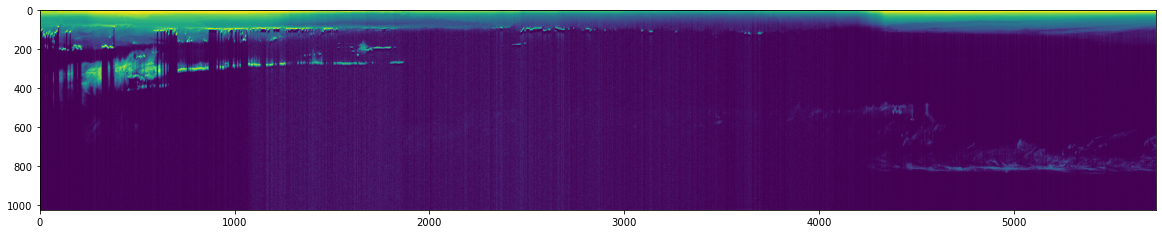

In [17]:
figure, ax = plt.subplots(figsize = (20,12))

#often times some correcting needs to be done


#clipping to get rid of negative values and plotting in log10:

clipped_data = np.clip(data_yalis, 0.001, 1.0)
log_data = np.log10(clipped_data)

ax.imshow(log_data)    #imshow() for displaying a 2D data field 

plt.show()

**Regressions and Curve Fitting**

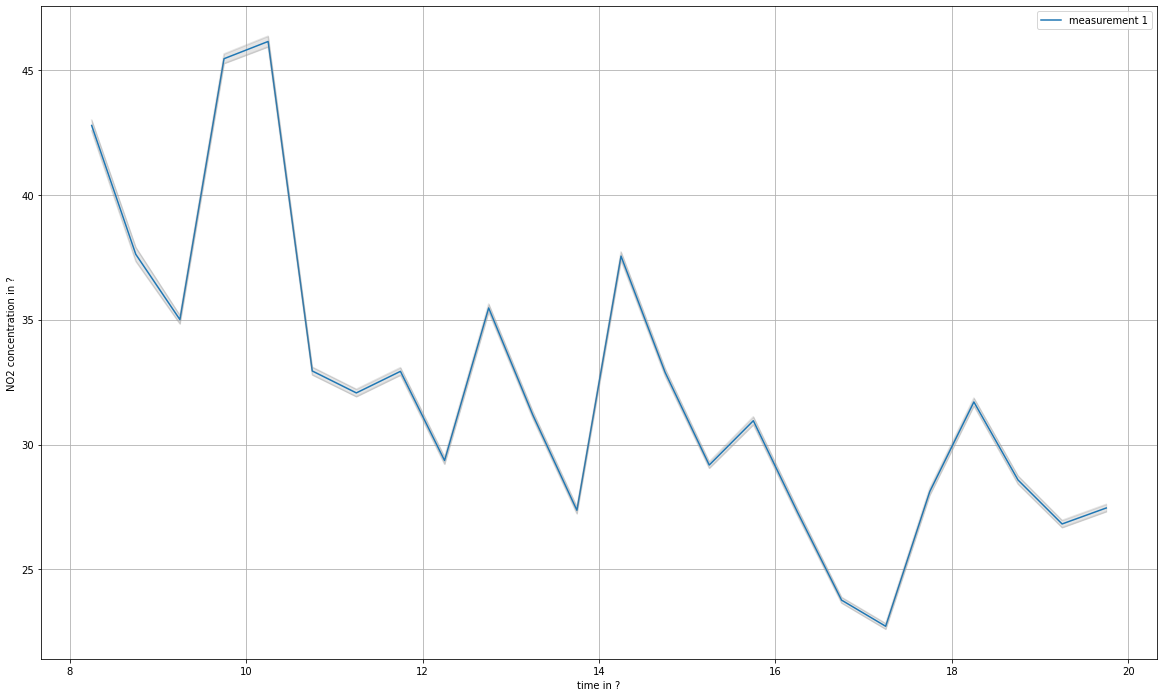

In [26]:
#let's look at the DOAS NO2 measurements now

t = (data_doas[:,0]-735090)*24
measure1 = data_doas[:,1]
uncert1 = data_doas[:,2]
measure2 = data_doas[:,3]
uncert2 = data_doas[:,4]
measure3 = data_doas[:,5]
uncert3 = data_doas[:,6]

fig, ax = plt.subplots(figsize = (20,12))

plt.plot(t, measure1, label = 'measurement 1')
plt.plot(t, measure1+uncert1, color = 'gray', alpha = 0.2)
plt.plot(t, measure1-uncert1, color = 'gray', alpha = 0.2)
plt.fill_between(t, measure1+uncert1, measure1-uncert1, color = 'gray', alpha = 0.2)
plt.legend()
plt.grid()
plt.xlabel('time in ?')
plt.ylabel('NO2 concentration in ?')
plt.show()

In [3]:
#principal component analysis

CO2_con2 = CO2_cor * 2
CO_con2 = CO_cor * 2
NOx_con2 = NOx_cor * 2
PM_con2 = PM_cor * 2

emissionrates=np.array([[0.5,1.0],[0.25,0.08],[0.025,0.005]])

source_strength_CO2 = emCO2 * traffic

d = CO2_con2 / source_strength_CO2

b = np.vstack((CO_con2/d, NOx_con2/d, PM_con2/d))
par, res, rank, sing_val = np.linalg.lstsq(emissionrates, b)

diesel_car = par[0]
gas_car = par[1]

plt.plot(t, diesel_car, label = 'diesel')
plt.plot(t, gas_car, label = 'gas')
plt.legend()

NameError: name 'CO2_cor' is not defined

In [44]:
#linear least sqaures: A * x = b, with b being the measurement values and x being unknown parameters
#we want to determine x in a way that the residual r = b - A*x is minimised (=cost function)
#A is consisting of the measurements at their observed location -> A is a m x n matrix with m being the number of measurements = len(b)
#while n is the number of "locations" or principal components
#need to solve x = (A.T*A)**(-1) * A.T * b 
#with (A.T*A)**(-1) * A.T being the Moore-Penrose pseudeinverse

#For regressing measure1 A is also only consisting of one column of 1s and second column = t

A = np.vstack((np.ones(t.shape[0]),t)).T

#in python I can do this as a Ordinary Least Squares Regression
x1 = np.linalg.pinv(A).dot(measure1)
linreg1 = x1[0] + x1[1] * t
#or straight away, also OLS
x2, residual, rank, sing_val = np.linalg.lstsq(A, measure1, rcond = None)
linreg2 = x1[0] + x1[1] * t

#if we want to weigh our regression regarding its uncertainty:
w = np.diag(1/uncert1**2)
x_weighted = np.linalg.inv(A.T.dot(w).dot(A)).dot(A.T).dot(w).dot(measure1)
linreg_weighted = x_weighted[0] + x_weighted[1] * t

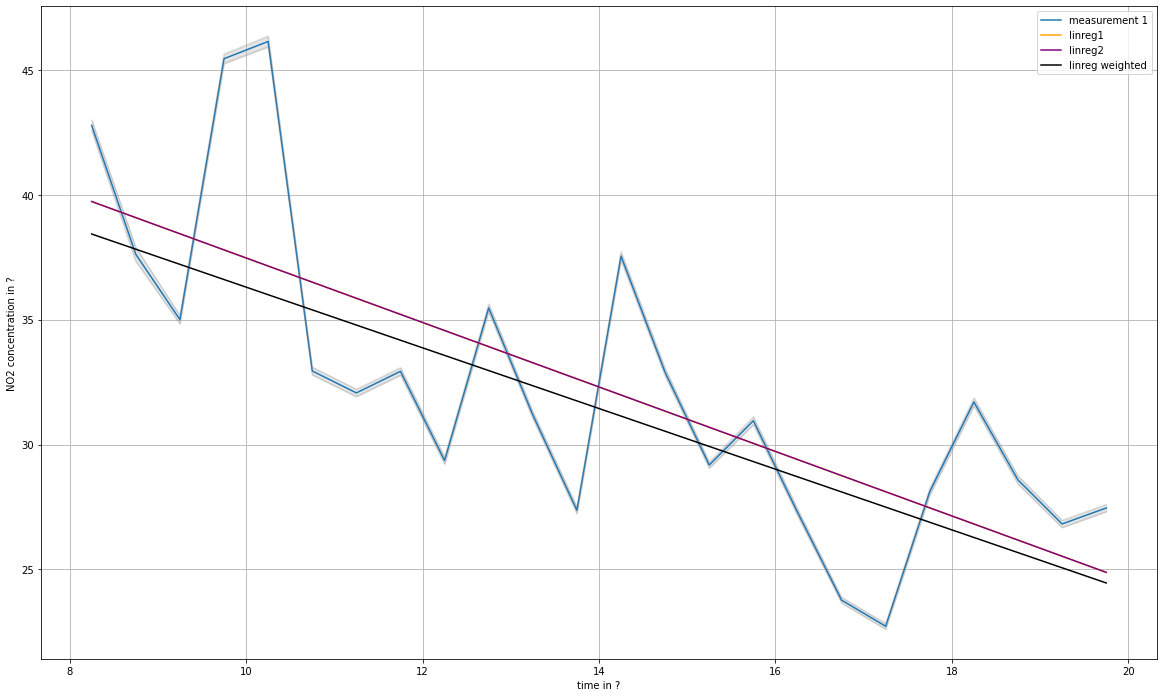

In [45]:
fig, ax = plt.subplots(figsize = (20,12))

plt.plot(t, measure1, label = 'measurement 1')
plt.plot(t, measure1+uncert1, color = 'gray', alpha = 0.2)
plt.plot(t, measure1-uncert1, color = 'gray', alpha = 0.2)
plt.plot(t, linreg1, color = 'orange', label = 'linreg1')
plt.plot(t, linreg2, color = 'purple', label = 'linreg2')
plt.plot(t, linreg_weighted, color = 'k', label = 'linreg weighted')
plt.fill_between(t, measure1+uncert1, measure1-uncert1, color = 'gray', alpha = 0.2)
plt.legend()
plt.grid()
plt.xlabel('time in ?')
plt.ylabel('NO2 concentration in ?')
plt.show()

In [ ]:
#Non Linear Curve Fitting by using SciPy

# fit two gaussian curves

fit_func = lambda t, off, xm1, s1, a1, xm2 , s2, a2: off + a1 * np.exp(-(t-xm1)**2/(2*s1**2)) + a2 * np.exp(-(t-xm2)**2/(2*s2**2)) 

opt_par, opt_cov = opt.curve_fit(fit_func, t, gas_car)

opt_par

plt.plot(fit_func(t,  *opt_par))
plt.plot(gas_car)

In [ ]:
emissionrates=np.array([[0.5,1.0],[0.25,0.08],[0.025,0.005]])

source_strength_CO2 = emCO2 * traffic

d = CO2_con2 / source_strength_CO2

par, res, rank, sing_val = np.linalg.lstsq(emissionrates, b)

diesel_car = par[0]
gas_car = par[1]

plt.plot(t, diesel_car, label = 'diesel')
plt.plot(t, gas_car, label = 'gas')
plt.legend()